The code in this notebook will serve as the basis for the CSCI 3352 final project for spring 2020. 

**Name:** Nicholas Palmer 

**Date:** 1/4/2020

The purpose of this project will be to investigate how graph structure affects the spread of a contagion through a population. The idea with this type of project is to see what strategies for modifying graph structure can be used to "flatten the curve" effectively so that the health care system will not be overwhelmed by the pandemic. 

In [1]:
import networkx as nx
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pylab as plt
import random as rnd
import copy
import glob
import pandas as pd

%matplotlib inline

plt.rcParams['figure.figsize'] = 20,15
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# Importing Haggle Human Proximity Network

We first wish to get a network that represents human proximity. Here, we pull in the Haggle Human Proximity Network, which was generated by using wireless network interfaces such as cellphones or PDAs to determine when people were physically close together. A link to the network can be found here: https://ieeexplore.ieee.org/document/4161914

In [2]:
#Read the file in line by line. Add contents to dictionary
#This approach was chosen because there were extraneous data in the edge list
#Additionally, the list of times needed to be preserved
edge_list = open('data/contacts.txt', 'r')
edges_lines = edge_list.readlines()

#The edges in the graph from the proximity data
edges = []
simple_edges = []
#Store each interaction in the dataset
for line in edges_lines:
    edge_values = line.split()
    edge = (int(edge_values[1]), int(edge_values[0]), 1)
    simple_edge = (int(edge_values[1]), int(edge_values[0]))
    edges.append(edge)
    simple_edges.append(simple_edge)
    
#Remove duplicate edges for an undirected graph
simple_edges = list(dict.fromkeys(simple_edges))

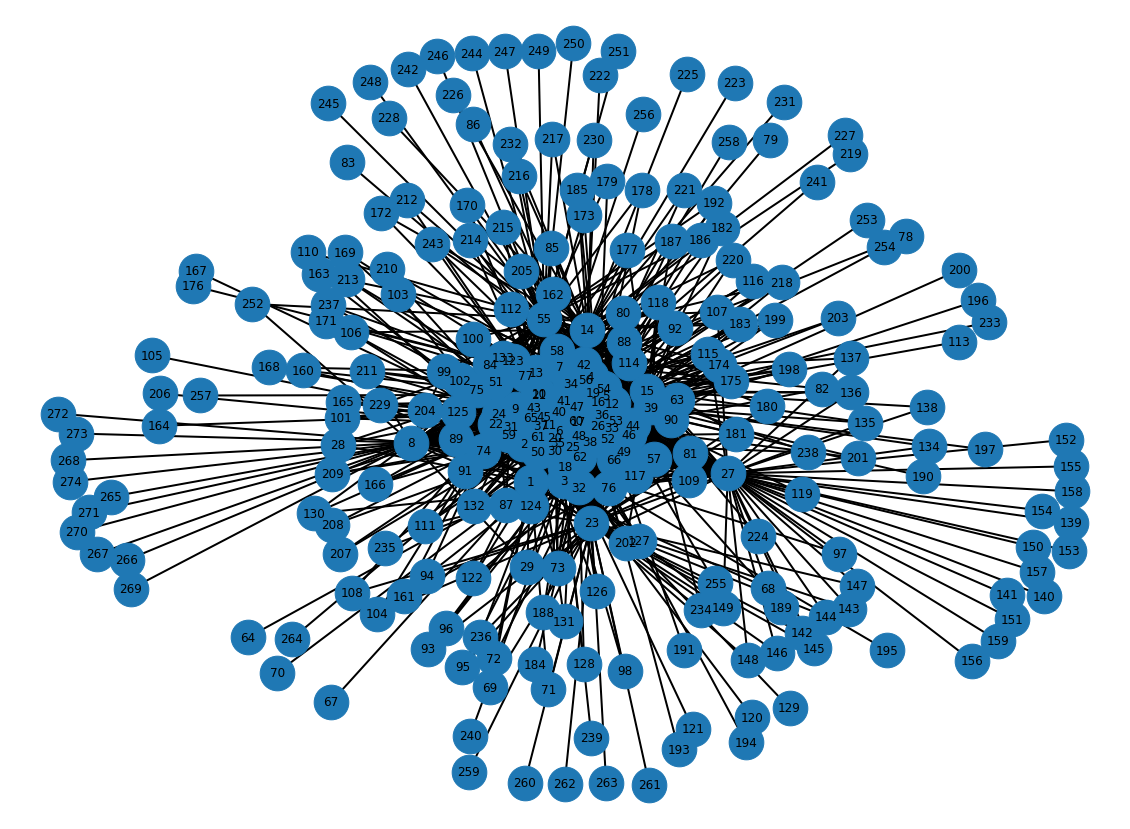

In [3]:
interaction_network = nx.Graph(simple_edges)

#Draw a rediculogram for the memes
nx.draw_networkx(interaction_network, with_labels=True, node_size=1200, width=2)
limits=plt.axis('off')
plt.show()

The cell above shows the rediculogram for the Haggle Human Proximity Network. This will allow us to run simulations on the graph for how contagion spreads. 

<hr>

# Defining the SAYER Simulation

Now we wish to define our simulation. This simulation will allow for a modified SIR model. The simulation will split the infected group into the following categories: 
*Susceptible
*Asymptomatic
*sYmptomatic
*sEvere
*Recovere/Removed

It will also implement social distancing with strength $\alpha$ after a given percentage of the population has been infected. 

It also defines a probability $m$, which is the global mixing probability. Each day, when an individual interacts with others, they will interact with the public with probability $m$. That is, they interact with nodes who are not their neighbors that day. Otherwise they interact with their neighbors. 

In [4]:
#Draw graphs with a labelling
#Used during simulation
def drawGz(G,z):
    colors = {'S':'#99FF99', 'A':'#FFB570', 'Y':'#FF99CC', 'E':'#FF3333', 'R':'#6666FF'}

    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[z[i]])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
        
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

#Draw graphs without a labelling
#Useful for testing new types of graphs before simulating
def draw_G(G):
    print(f'graph with n={G.order()} nodes and m={G.size()} edges:')
    limits=plt.axis('off') 
    nx.draw_networkx(G,with_labels=True,node_size=600,width=2) # draw it pretty                                    # turn off axes
    plt.show()
    return

#Generate a healty population labeling. All nodes susceptible
def generateZt(G, initial_infected, At_initial, Yt_initial):
    zt = {}
    for node in G.nodes():
        zt[node] = 'S' #Initially make all nodes susceptible
        
    initial_keys = list(np.random.choice(list(zt.keys()), initial_infected, replace=False))
    for key in initial_keys[0:At_initial]:
        zt[key] = 'A'
    
    for key in initial_keys[At_initial:At_initial+Yt_initial]:
        zt[key] = 'Y'
    
    for key in initial_keys[At_initial+Yt_initial:]:
        zt[key] = 'E'    
    
    return zt

#Check the beta and gamma values for each infected group to ensure they are reasonable
#Also check for the average R_0 value to ensure it is reasonable
def checkBetaAndGamma(group_coefficients):
    r0s = []
    r0s.append(group_coefficients['A'][0]/group_coefficients['A'][1])
    r0s.append(group_coefficients['Y'][0]/group_coefficients['Y'][1])
    r0s.append(group_coefficients['E'][0]/group_coefficients['E'][1])
    average_r0 = np.mean(r0s)
    
    print("R0 for the asymptomatic group is " + str(r0s[0]))
    print("R0 for the symptomatic group is " + str(r0s[1]))
    print("R0 for the severe group is " + str(r0s[2]))
    print("The average R0 for this infection is " + str(average_r0))

#Implement simple social distancing on the graph G
#Delete each edge with probability alpha
def socialDistance(G, alpha):
    if(alpha == 0):
        return G
    for u, v in G.edges():
        #Remove with probability alpha
        if(np.random.rand(1)[0] < alpha):
            G.remove_edge(u, v)
    return G
    
#Description: 
#Runs a parameterized simulation of the SASER model on a given network
#Parameters:
#G: The network which the simulation runs on
#initial_infected: The number of infected individuals at t=1. The first individual is chosen to be symptomatic. The rest are chosen randomly
#severity_pdf: The probability density function for each level of severity when an individual becomes infected
#group_coefficients: A dictionary containing tuples for beta and gamma values for each of the A, Y, and E groups
#global_p: The global mixture probability. The probability that individuals interact with a random, non-adjacent node
#percent_infected: The percent of the population that must be infected before implementing social distancing
#alpha: Probability of deleting each edge in the network after social distancing is implemented
#verbose: A flag for verbose printing. Not recommended for large graphs
#draw: Boolean flag for drawing the network at each step of the simulation. Not recommended for large graphs
def runSAYER(G, initial_infected, severity_pdf, group_coefficients, global_p, percent_infected, alpha, verbose=False, draw=False):
    #Make sure that G is a deep copy so as not to change the original
    G = copy.deepcopy(G)
                
    #Optionally print some information about R0
    if(verbose):
        checkBetaAndGamma(group_coefficients)
    
    St = [] # S(t), time series of number of Susceptible nodes per time step t
    At = [] # A(t), time series of number of Asymptomatic nodes per time step t
    Yt = [] # S(t), time series of number of sYmptomatic nodes per time step t
    Et = [] # E(t), time series of number of sEvere nodes per time step t
    Rt = [] # R(t), time series of number of R nodes per time step t
    
    It = [] # I(t), time series of number of Infected nodes per time step t (total)
    t  = 1 #Simulation clock
    
    infected_groups = list(group_coefficients.keys()) #Possible labels for infected individuals
    
    #Choose which groups the initial infected individuals fall into
    patient_zeros = list(np.random.choice(infected_groups, initial_infected, severity_pdf))
    At_initial = patient_zeros.count('A')
    Yt_initial = patient_zeros.count('Y')
    Et_initial = patient_zeros.count('E')
    
    #Initialize timeseries arrays with the proper number of individuals
    St.append(len(G.nodes()) - initial_infected)
    At.append(At_initial)
    Yt.append(Yt_initial)
    Et.append(Et_initial)
    Rt.append(0)
    
    It.append(initial_infected)
    
    #Optionally print some information about the first infected individuals
    if(verbose):
        print("Count of patient zero(s):")
        print("Asymptomatic: " + str(At_initial))
        print("Symptomatic: " + str(Yt_initial))
        print("Severe: " + str(Et_initial))
    
    #Initialize the labelling with patient zeroes
    #This method was chosen to reduce computation time in setting labels from a group of 3
    zt = generateZt(G, initial_infected, At_initial, Yt_initial)
    
    #Optionally draw the graph at the first time step
    if(draw):
        print(f'time step {t}')
        drawGz(G,zt)
    distancingFlag = False
    #Run the simulation while there are any people in infected groups
    while any(infected_group in zt.values() for infected_group in infected_groups):
        #Check if social distancing will be implemented
        if(distancingFlag == False):
            if(It[t-1]/len(G.nodes()) >= percent_infected):
                
                if(verbose):
                    print("Implementing social distancing at time t=" + str(t))
                
                #Social distancing is implemented
                G = socialDistance(G, alpha)
                distancingFlag = True #Don't implement social distancing again 
        
        zu = copy.deepcopy(zt) # nodes states for the previous time step (synchronous updates)

        #Loop over each node in the network
        for individual in G.nodes():
            #Choose whether a node interacts with its neighbors or a random node in the population
            #This section of code simulates S -> A, Y, E transitions
            
            #Choose random nodes in the network to interact with
            num_interactions_high = G.degree[individual] + 1
            num_interactions = np.random.randint(0, num_interactions_high)
            
            individual_status = zu[individual] #The status of the individual being evaluated 
            if np.random.rand(1)[0] < global_p:
                
                strangers = np.random.choice(G.nodes(), num_interactions)
                
                for stranger in strangers:
                    stranger_status = zu[stranger]
                    
                    #Check if the stranger is susceptible to infection
                    if(individual_status in infected_groups and stranger_status == 'S'):
                        #Pick a severity group for a potential infection
                        severity_group = np.random.choice(infected_groups, p=severity_pdf)

                        #Do a check on whether the stranger gets infected
                        if(np.random.rand(1)[0] < group_coefficients[severity_group][0]):
                            #Infect the stranger. Choose one of the groups to put them into
                            zt[stranger] = severity_group

                    #Check if the individual is susceptible to infection
                    if(stranger_status in infected_groups and individual_status == 'S'):
                        #Pick a severity group for a potential infection
                        severity_group = np.random.choice(infected_groups, p=severity_pdf)

                        if(np.random.rand(1)[0] < group_coefficients[severity_group][0]):
                            zt[individual] = severity_group
                        
            else:
                #TODO: Add functionality for proximity interactions here
                #Simulate the individual interacting with nodes that are adjacent to them
                neighbors = np.random.choice(list(G.neighbors(individual)), num_interactions)
                
                for neighbor in neighbors:
                    stranger = neighbor
                    stranger_status = zu[stranger]
                    #TODO: make this a nested function to keep it DRY and KISS
                    #Check if the stranger is susceptible to infection
                    if(individual_status in infected_groups and stranger_status == 'S'):
                        #Pick a severity group for a potential infection
                        severity_group = np.random.choice(infected_groups, p=severity_pdf)

                        #Do a check on whether the stranger gets infected
                        if(np.random.rand(1)[0] < group_coefficients[severity_group][0]):
                            #Infect the stranger. Choose one of the groups to put them into
                            zt[stranger] = severity_group

                    #Check if the individual is susceptible to infection
                    if(stranger_status in infected_groups and individual_status == 'S'):
                        #Pick a severity group for a potential infection
                        severity_group = np.random.choice(infected_groups, p=severity_pdf)

                        if(np.random.rand(1)[0] < group_coefficients[severity_group][0]):
                            zt[individual] = severity_group
            
            #Simulate recovery transitions. A,Y,E -> R
            if(zu[individual] in infected_groups):
                if(np.random.rand(1)[0] < group_coefficients[individual_status][1]):
                    zt[individual] = 'R'

        t += 1 # update clock
        
        #Optionally draw at each step
        if(draw):
            print(f'time step {t}')
            drawGz(G,zt)

        #Update the time series for Z
        #TODO: Update this for the different categories
        s_curr = 0
        a_curr = 0
        y_curr = 0
        e_curr = 0
        r_curr = 0
        for key,value in zt.items():
            if(value == 'S'):
                s_curr += 1
            elif(value == 'A'):
                a_curr += 1
            elif(value == 'Y'):
                y_curr += 1
            elif(value == 'E'):
                e_curr += 1
            elif(value == 'R'):
                r_curr += 1

        St.append(s_curr)
        At.append(a_curr)
        Yt.append(y_curr)
        Et.append(e_curr)
        Rt.append(r_curr)
        It.append(a_curr + y_curr + e_curr)
    
    return t, It, St, At, Yt, Et, Rt


#Plot results of the SAYER model simulation
def plotSAYER(t, It, St, At, Yt, Et, Rt, title='SAYER Model Totals'):
    x_time = np.arange(1, t+1)
    plot_line_width = 4
    colors = {'S':'#99FF99', 'A':'#FFB570', 'Y':'#FF99CC', 'E':'#FF3333', 'R':'#6666FF'}
    plt.plot(x_time, It, color="black", label="Total Infections", linewidth=plot_line_width)
    plt.plot(x_time, St, color=colors['S'], label="Susceptible", linewidth=plot_line_width)
    plt.plot(x_time, At, color=colors['A'], label="Asymptomatic", linewidth=plot_line_width)
    plt.plot(x_time, Yt, color=colors['Y'], label="Symptomatic", linewidth=plot_line_width)
    plt.plot(x_time, Et, color=colors['E'], label="Severe", linewidth=plot_line_width)
    plt.plot(x_time, Rt, color=colors['R'], label="Recovered/Removed", linewidth=plot_line_width)
    plt.grid(b=True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Days")
    plt.ylabel("Number of Individuals")
    plt.title(title)
    plt.show()

Now that the simulation is defined, let us run a sample simulation on the network that we imported from ICON.

R0 for the asymptomatic group is 4.0
R0 for the symptomatic group is 1.6666666666666667
R0 for the severe group is 1.3333333333333335
The average R0 for this infection is 2.3333333333333335
Count of patient zero(s):
Asymptomatic: 1
Symptomatic: 0
Severe: 0
Implementing social distancing at time t=4


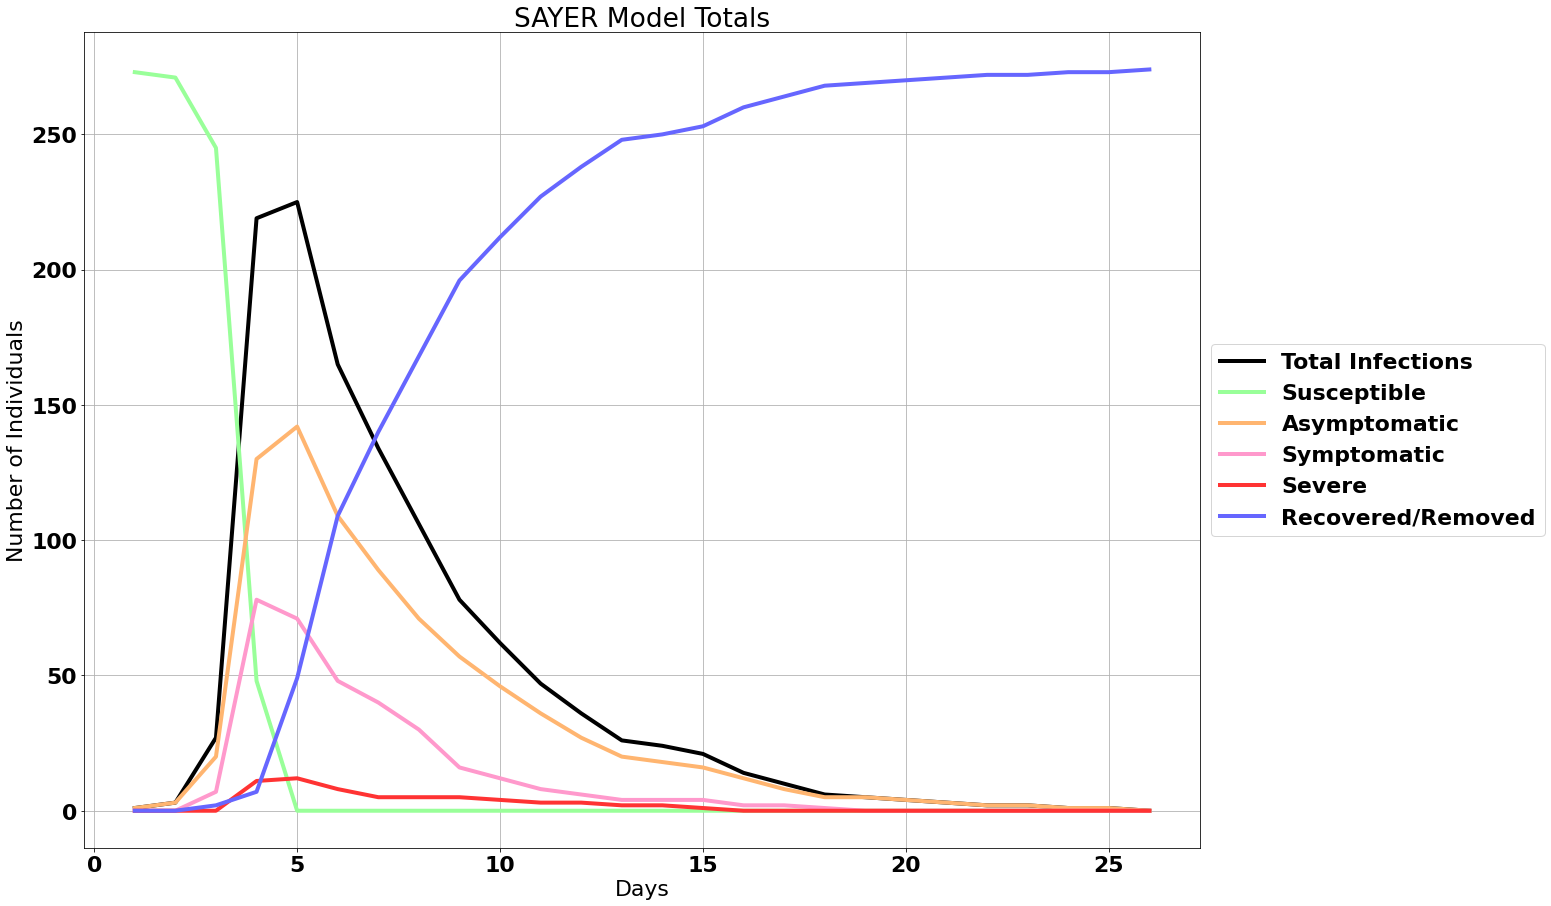

In [5]:
#Try out some beta and gamma values 
asymptomatic_beta = .8
asymptomatic_gamma = .2
symptomatic_beta = .5 
symptomatic_gamma = .3
severe_beta = .4
severe_gamma = .3

#Define the group_coefficients dictionary for the simulation
#This was chosen to avoid passing an additional 6 arguments to the sim function
group_coefficients = {'A':(asymptomatic_beta, asymptomatic_gamma), 'Y':(symptomatic_beta, symptomatic_gamma), 'E':(severe_beta, severe_gamma)}

#Other parameters for the simulation
initial_infected = 1
severity_pdf = [0.5, 0.42, 0.08]
global_p = 0.5

#Run the SASER model
t, It, St, At, Yt, Et, Rt = runSAYER(interaction_network, initial_infected, severity_pdf, group_coefficients, global_p, 0.1, 0, verbose=True, draw=False)

#Plot the results of the SAYER simulation from the proximity data
plotSAYER(t, It, St, At, Yt, Et, Rt)

The above plot shows the spread of the infection nicely. We can see that the three infected groups add up to the total number of infections shown in black at each step. Additionally we can see the number of susceptible and recovered individuals at each step. Now that we have verified that the simulation works, we can begin to work on creating a larger graph to run our simulations on. 

<hr>

# Creating Large Representative Graphs

First, let us investigate how well the Chung-Lu model will be able to represent the proximity data that we pulled in from ICON.

In [133]:
#Examine whether various attributes from the generated graphs can explain the empirical graph
#This function was provided in the notebook for problem set 3
def plot_nullAndEmpirical(nulls,emp,qlabel,nlabel,elabel,xlim,ylim):
    # input: nulls, a list of values representing a null (reference) distribution
    #        emp, the empirical value to be compared to the null
    #        qlabel [string], the name of the empirical quantity, e.g., '<ell>' or 'C'
    #        nlabel [string], the name of the null data series
    #        elabel [string], the name of the empirical data source
    #        xlim [scalar], the upper limit of the x-axis
    #        ylim [scalar], the upper limit of the y-axis

    counts, bins = np.histogram(nulls,bins=50,range=(0,xlim), density=True)
    nreps = len(nulls)

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    plt.plot(bins[:-1], counts/nreps, 'b-', alpha=0.5, label=nlabel)
    plt.plot([emp, emp], [0, ylim], 'r-', alpha=0.5, label=elabel)
    plt.xlabel(qlabel)
    plt.ylabel('Pr('+qlabel+')')
    plt.xlim(0, xlim)
    plt.legend(loc='upper right');
    plt.show()
    
    return

#Compute the mean geodesic distance of the graph
#This function was taken from problem set three. This function is my own work
def compute_MGD(G):
    # input : a networkx graph G
    # output: the mean geodesic path length (defined in Lecture 2)
    #Track Z and the geodesic path length sum
    z = 0
    geo_path_length_sum = 0
    
    #Get all pairs of geodesic path lengths
    path_dict = nx.all_pairs_shortest_path_length(G)
    
    for source_node, source_dict in path_dict:
        for path_len in source_dict.values():
            if(path_len > 0):
                z += 1
                geo_path_length_sum += path_len
    
    return (geo_path_length_sum / z)

def compute_kmean(G):
    kmean = 0
    for node in G.nodes():
        kmean += G.degree(node)
    kmean /= len(G.nodes())
    return kmean

In [136]:
n = len(interaction_network.nodes())
m = len(interaction_network.edges())

kmean = compute_kmean(interaction_network)

C = nx.transitivity(interaction_network)

ellmean = compute_MGD(interaction_network)

In [134]:
Cs   = []  # store the null values of C here
ells = []  # store the null values of ellmean here
kmeans = []

# YOUR CODE HERE
#Get the degree sequence of the P. pacificus network
degree_sequence = [d for n, d in interaction_network.degree]

for _ in range(200):
    #Generate the chung lu graph with no self loops from the degree sequence
    chung_lu = nx.expected_degree_graph(degree_sequence, selfloops=False)
    
    Cs.append(nx.transitivity(chung_lu))
    ells.append(compute_MGD(chung_lu))
    kmeans.append(compute_kmean(chung_lu))

0.5608257330648044


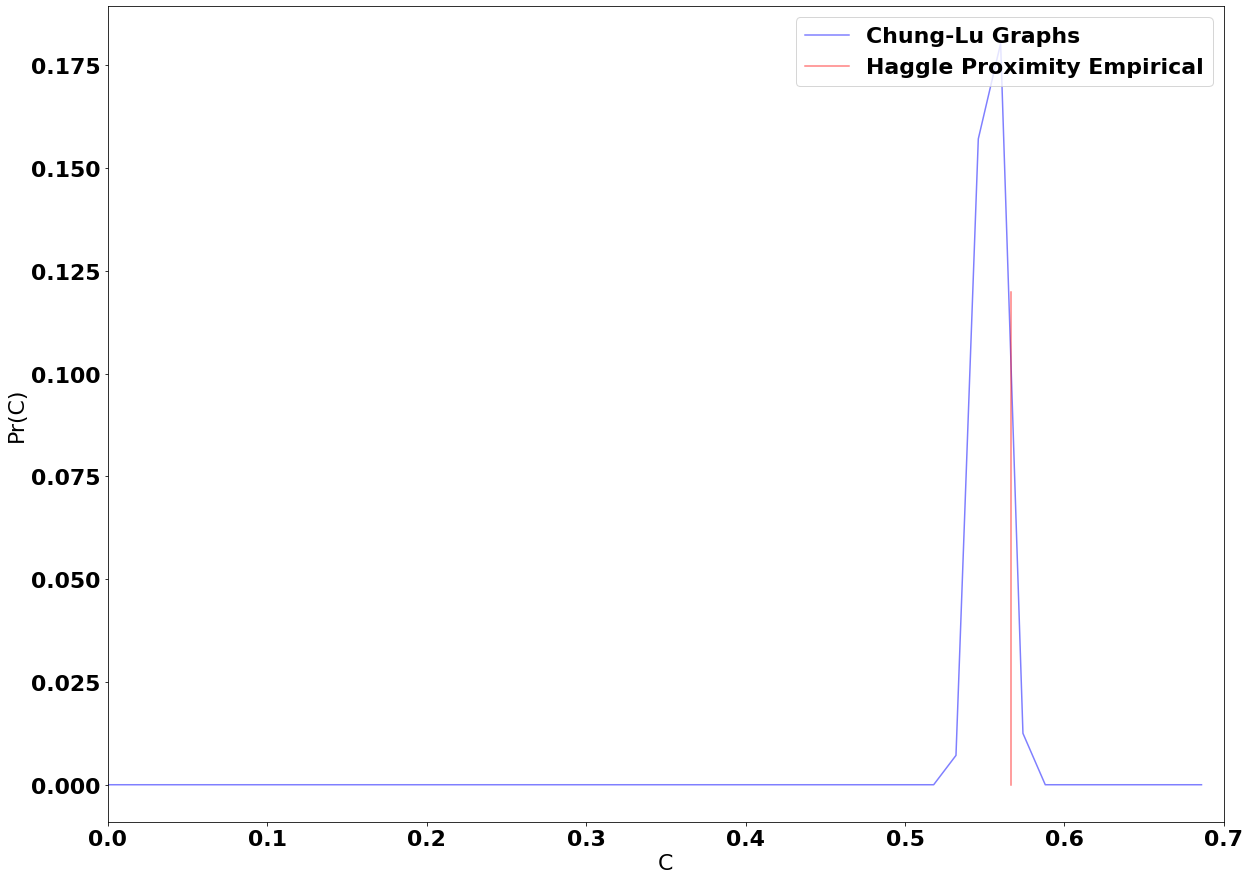

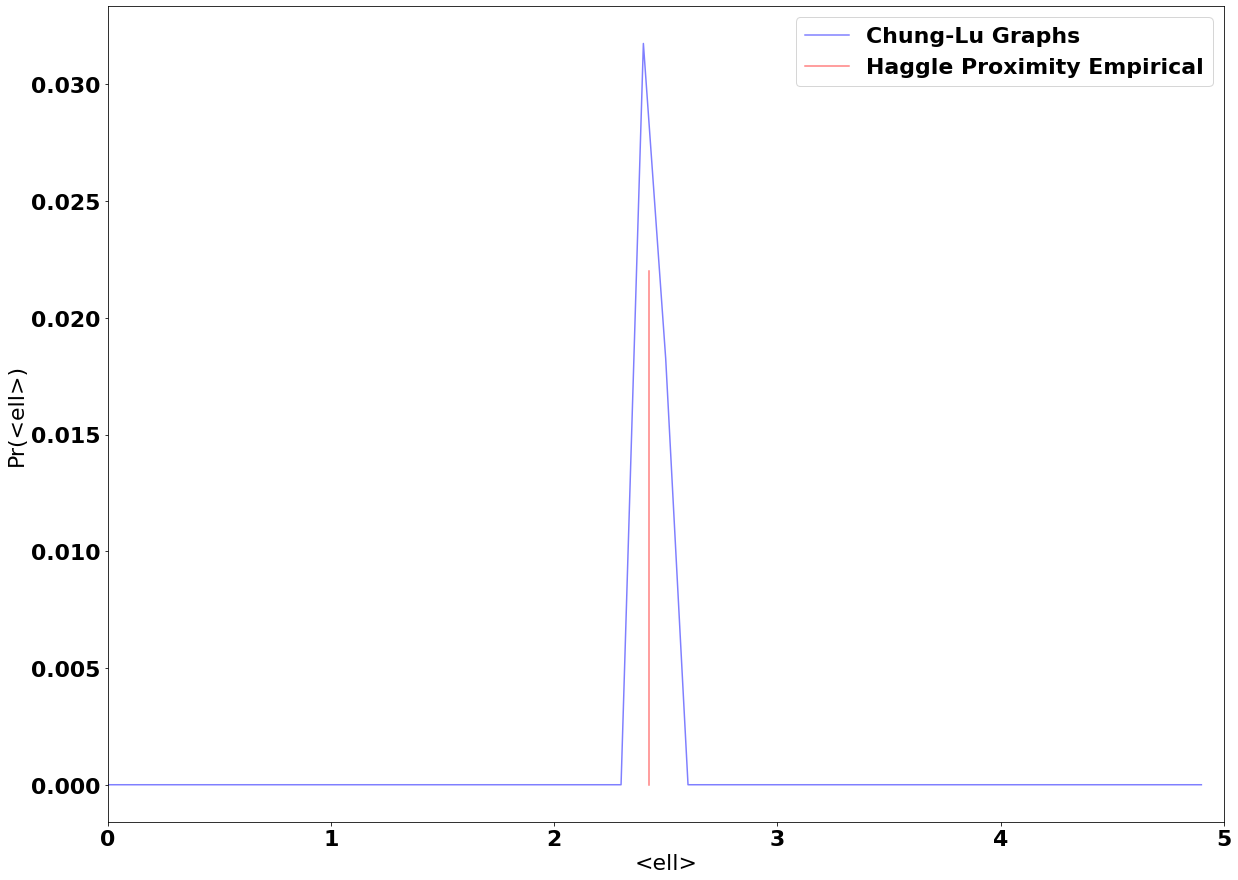

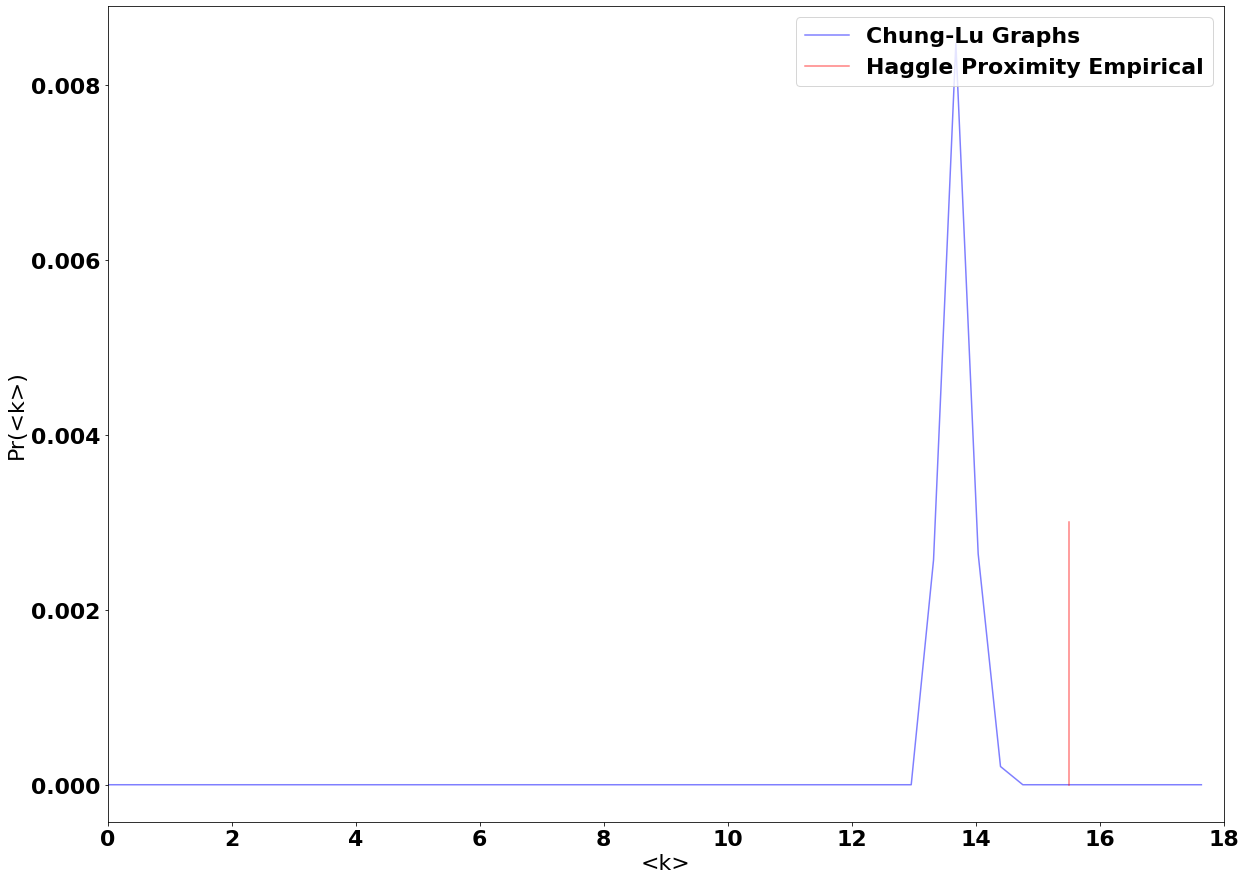

In [135]:
print(np.mean(Cs))
plot_nullAndEmpirical(Cs,C,'C','Chung-Lu Graphs','Haggle Proximity Empirical',0.7,0.12)
plot_nullAndEmpirical(ells,ellmean,'<ell>','Chung-Lu Graphs','Haggle Proximity Empirical',5,0.022)

plot_nullAndEmpirical(kmeans,kmean,'<k>','Chung-Lu Graphs','Haggle Proximity Empirical',18,0.003)

From the cells above, we can see that the reference distributions calculated from the Chung-Lu graph can explain the transitivity and mean geodesic distance in the Haggle Proximity Network. However, it is not able to explain the mean degree of the network. Despite this fact, it should still make a good approximation for the network when creating random graphs for the purpose of epidemic simulation. 

We will use the approach of the `nx.relaxed_caveman_graph` function to generate cliques that are connected together. However, the issue with `nx.relaxed_caveman_graph` is that each clique is fully connected, and then edges are randomly rewired with probability $p$. Instead, we wish to make each clique representative of the empirical proximity data, generate several cliques, and then randomly rewire each edge with probability $p$. 

In [6]:
#Generate a county graph using the chung-lu model for cliques
#Parameters:
#degree_sequence: The expected degree sequence for the chung_lu model
#l: The number of cliques in the network
#p: The probability of rewiring each edge in the network
def county_graph(degree_sequence, l, p):
    #Generate the first clique
    county_graph = nx.expected_degree_graph(degree_sequence, selfloops=False)
    
    #Add l-1 additional cliques to the existing graph
    for _ in range(0, l-1):
        #Generate a clique to add to the existing county
        addition = nx.expected_degree_graph(degree_sequence, selfloops=False)
        
        #Force a disjoint union in the network
        county_graph = nx.disjoint_union(county_graph, addition)
        
    nodes = list(county_graph)
    
    #Loop over all edges and randomly rewire them with probability p
    for (u,v) in county_graph.edges():
        #Choose whether to rewire with probability p
        if(np.random.rand(1)[0] < p):
            new_end = np.random.choice(nodes)
            
            if(county_graph.has_edge(u, new_end)):
                continue
                
            county_graph.remove_edge(u, v)
            county_graph.add_edge(u, new_end)
            
#     county_graph.remove_nodes_from(list(nx.isolates(county_graph))) 
    for component in list(nx.connected_components(county_graph)):
        if(len(component)<5):
            for node in component:
                county_graph.remove_node(node)
            
    return county_graph

The above cell defines the `county` graph generator, which will allow us to generate graphs that contain interconnected cliques. Below we show an example of a 3-clique county with q=0.01.

graph with n=708 nodes and m=5718 edges:


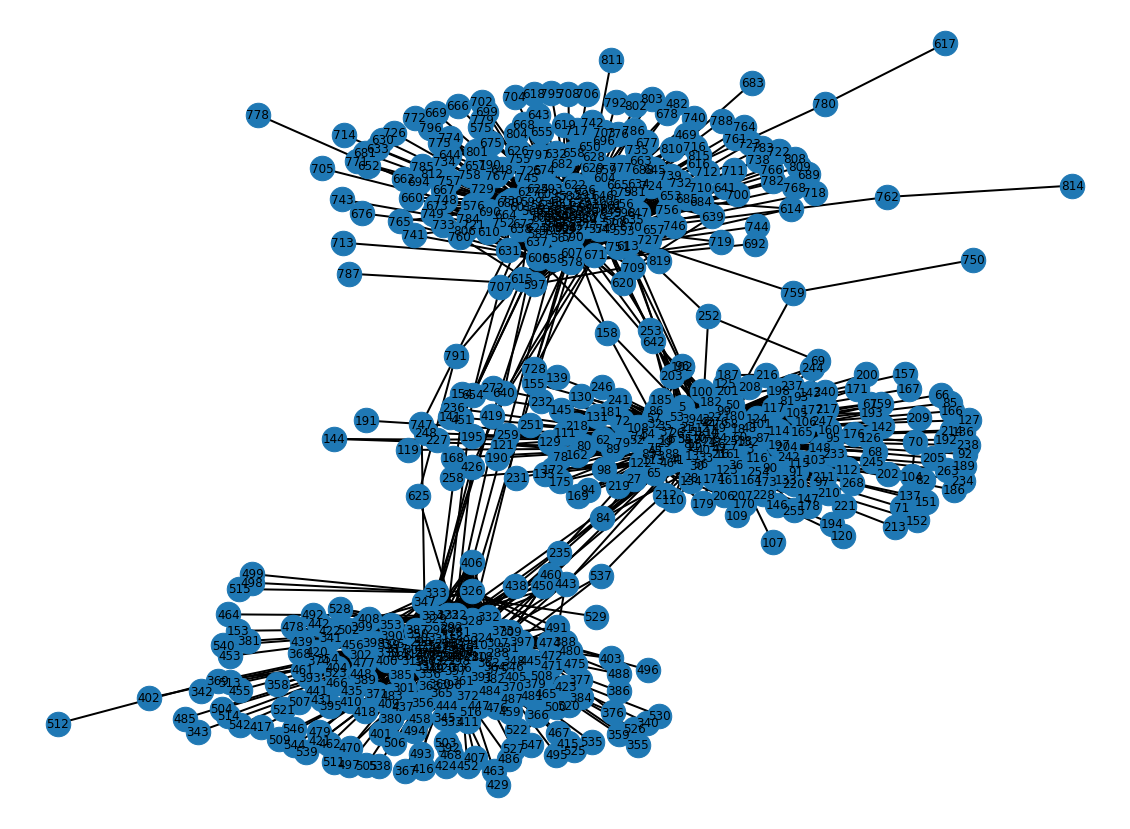

In [7]:
degree_sequence = [d for n, d in interaction_network.degree]
example_county = county_graph(degree_sequence, 3, 0.01)
draw_G(example_county)

Now that we have the basic simulator and graph generator up and running, the rest of the notebook will be example experiments that can be run using the simulator.

***

# Experiment: Varying Population Mixing

In the below experiment we define a SAYER experiment which will run multiple simulations and vary the global mixing probability to see how the simulations change with respect to this variable. 

In [11]:
def SAYER_experiment_p(G, global_p_arr, initial_infected, severity_pdf, group_coefficients, plot=False):
    It_arr = []
    for curr_p in global_p_arr:
        print(curr_p)
        t, It, St, At, Yt, Et, Rt = runSAYER(G, initial_infected, severity_pdf, group_coefficients, curr_p, 0.1, 0, verbose=False, draw=False)

        if(plot):
            plotSAYER(t, It, St, At, Yt, Et, Rt, title='SAYER Model Totals p=' + str(curr_p))

        It_arr.append(It)
    return It_arr

county = county_graph(degree_sequence, 30, 0.05)
global_p_arr = np.linspace(0, 1, 15)
It_arr = SAYER_experiment_p(county, global_p_arr, initial_infected, severity_pdf, group_coefficients, plot=False)

0.0
0.07142857142857142
0.14285714285714285
0.21428571428571427
0.2857142857142857
0.3571428571428571
0.42857142857142855
0.5
0.5714285714285714
0.6428571428571428
0.7142857142857142
0.7857142857142857
0.8571428571428571
0.9285714285714285
1.0


49
15
15


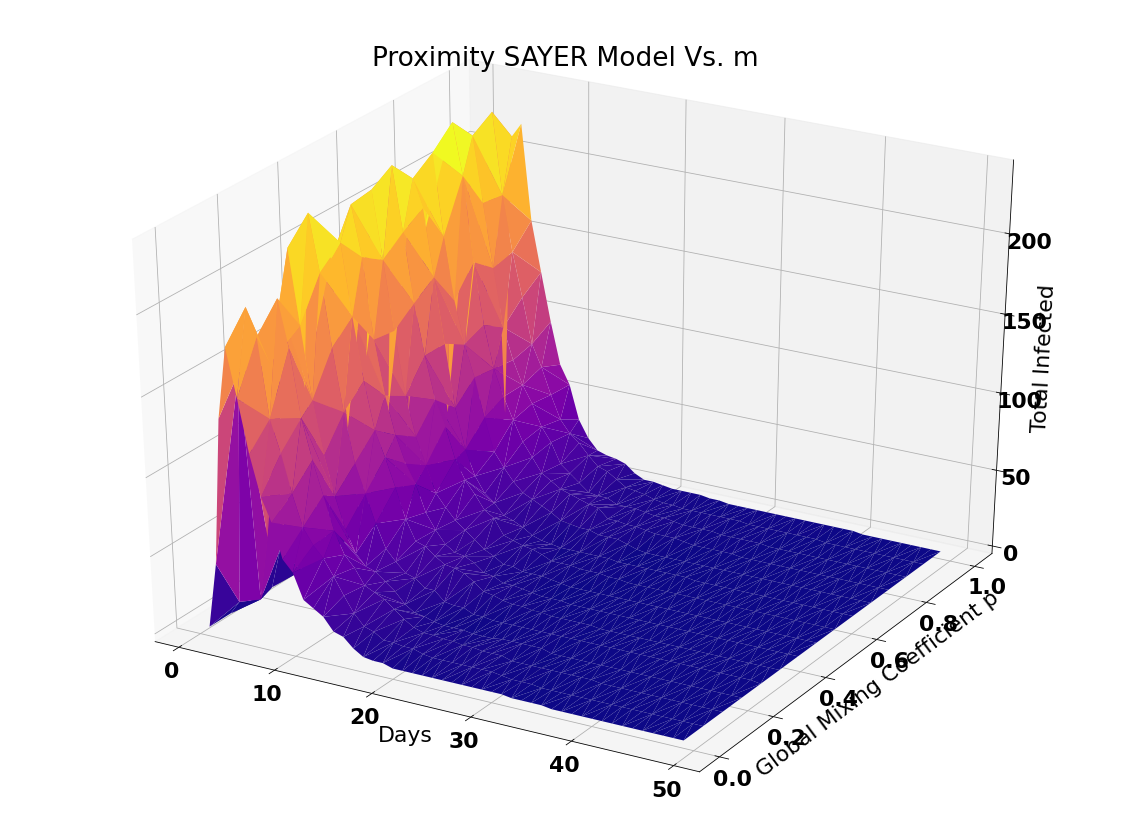

In [140]:
#Description: Evens out the dataframes from multiple simulation runs
#Parameters: 
#data: A list of lists of data
#extension: The data to extend shorter lists with. Usually the terminating criteria for the simulation
def evenOutData(data, extension):
    #Get the maximum length of a data row
    maxLen = max(map(len, data))
    for row in data:
        if(len(row) < maxLen):
            row.extend([extension] * (maxLen - len(row)))
    
    return data, maxLen

def plotSAYERExperiment(y_data, z_data, extension, title, xlabel, ylabel, zlabel):
    #Even out the data so that it has a consistent shape
    y_data, max_t = evenOutData(y_data, extension)
    x_data = np.arange(1, max_t + 1)
    
    print(len(x_data))
    print(len(y_data))
    print(len(z_data))
    
    #Generate x, y, z coordinates
    x = []
    y = []
    z = []
    
    for i in range(len(y_data)):
        for j in range(len(x_data)):
            x.append(x_data[j])
            y.append(y_data[i][j])
            z.append(z_data[i])
    
    
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(np.array(x), np.array(z), np.array(y), cmap='plasma')
    ax.set_title(title)
    ax.set_xlabel(xlabel, linespacing=10)
    ax.set_ylabel(zlabel)
    ax.set_zlabel(ylabel)
    ax.dist = 10

plotSAYERExperiment(It_arr, global_p_arr, 0, 'Proximity SAYER Model Vs. m', 'Days', 'Total Infected', 'Global Mixing Coefficient p')

From the cell above, we can see that the mixing probability has some effect on the peak of each simulation, but the effect isn't very strong. 

***

# Experiment: Varying When Social Distancing Occurs

In the following experiment we compare two simulations. The first simulation implements social distancing after 30% of the population is infected. The second simulation implements social distancing after just 2% of the population is infected. Each simulation is run on a county graph with $l = 30$ and $q = 0.05$. Additionally, for each simulation, the strength of social distancing is $q=0.9$.

In [9]:
def compare_SAYER(control_I, I, control_I_label, I_label, title, extension):
    #Even out the data
    maxLen = max(len(control_I), len(I))
    
    if(len(control_I) < maxLen):
        control_I.extend([extension] * (maxLen - len(control_I)))
    if(len(I) < maxLen):
        I.extend([extension] * (maxLen - len(I)))
        
    x_time = np.arange(1, maxLen+1)
    plot_line_width = 4
    plt.plot(x_time, control_I, color="red", label=control_I_label, linewidth=plot_line_width)
    plt.plot(x_time, I, color="blue", label=I_label, linewidth=plot_line_width)
    plt.grid(b=True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Days")
    plt.ylabel("Number of Individuals")
    plt.title(title)
    plt.show()

In [10]:
county = county_graph(degree_sequence, 30, 0.05)

#Try out some beta and gamma values 
asymptomatic_beta = .8
asymptomatic_gamma = .2
symptomatic_beta = .5 
symptomatic_gamma = .3
severe_beta = .4
severe_gamma = .3

#Define the group_coefficients dictionary for the simulation
#This was chosen to avoid passing an additional 6 arguments to the sim function
group_coefficients = {'A':(asymptomatic_beta, asymptomatic_gamma), 'Y':(symptomatic_beta, symptomatic_gamma), 'E':(severe_beta, severe_gamma)}

#Other parameters for the simulation
initial_infected = 1
severity_pdf = [0.5, 0.42, 0.08]
global_p = 0.5

#Run the SASER model
percent_infected = 0.02
alpha = 0.9
t, It, St, At, Yt, Et, Rt = runSAYER(county, initial_infected, severity_pdf, group_coefficients, global_p, percent_infected, alpha, verbose=False, draw=False)

percent_infected = 0.30
alpha = 0.9
t_later, It_later, St_later, At_later, Yt_later, Et_later, Rt_later = runSAYER(county, initial_infected, severity_pdf, group_coefficients, global_p, percent_infected, alpha, verbose=False, draw=False)

compare_SAYER(It_later, It, "30% Infected Before Social Distancing", "2% Infected Before Social Distancing", "SAYER Simulation When Social Distancing is Implemented", 0)

KeyboardInterrupt: 

From the above cell we can see that when social distancing is implemented can have a strong effect on the peak infection, as well as delaying the peak. This can provide valuable time to prepare for the peak and to reduce its severity. #flattenthecurve.

***

# Experiment: Varying The Strength of Social Distancing

In the following experiment, we vary the strength os social distancing. 

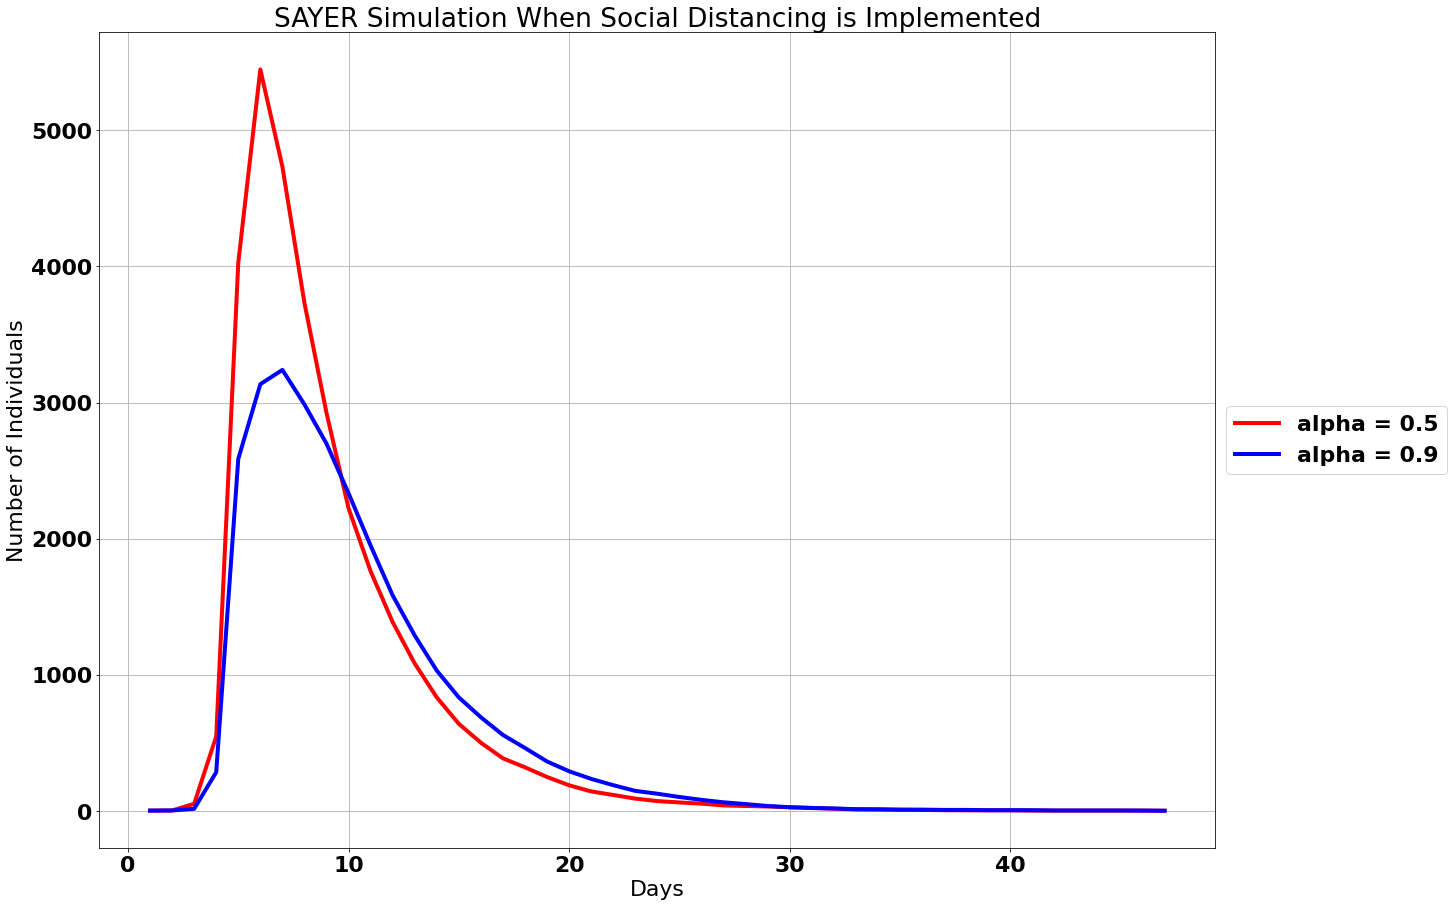

In [12]:
county = county_graph(degree_sequence, 30, 0.05)

#Try out some beta and gamma values 
asymptomatic_beta = .8
asymptomatic_gamma = .2
symptomatic_beta = .5 
symptomatic_gamma = .3
severe_beta = .4
severe_gamma = .3

#Define the group_coefficients dictionary for the simulation
#This was chosen to avoid passing an additional 6 arguments to the sim function
group_coefficients = {'A':(asymptomatic_beta, asymptomatic_gamma), 'Y':(symptomatic_beta, symptomatic_gamma), 'E':(severe_beta, severe_gamma)}

#Other parameters for the simulation
initial_infected = 1
severity_pdf = [0.5, 0.42, 0.08]
global_p = 0.5

#Run the SASER model
percent_infected = 0.30
alpha = 0.9
t, It, St, At, Yt, Et, Rt = runSAYER(county, initial_infected, severity_pdf, group_coefficients, global_p, percent_infected, alpha, verbose=False, draw=False)

percent_infected = 0.30
alpha = 0.5
t_later, It_later, St_later, At_later, Yt_later, Et_later, Rt_later = runSAYER(county, initial_infected, severity_pdf, group_coefficients, global_p, percent_infected, alpha, verbose=False, draw=False)

compare_SAYER(It_later, It, "alpha = 0.5", "alpha = 0.9", "SAYER Simulation When Social Distancing is Implemented", 0)

# Experiment: Varying When Social Distancing Occurs and How Strong Social Distancing Is

In the following experiment, we vary the strength of social distancing and when it occurs to see relationships between the two variables. This will help to determine when and how strongly social distancing should be to best mitigate the spread of an infection. 

Note that the below cell will take ~10+ hours to run depending on your hardware. A batch program has been provided which will run the experiment below 10 times, writing the data to a file each time. This allows for smooth plots to be generated. Note that the batch program will take about 6 days to run depending on your hardware. 

In [141]:
def runSocialDistanceExperiment(G, global_p_param, infected_percent_arr, alpha_arr, initial_infected, severity_pdf, group_coefficients, plot=False):
    alphas_x = []
    percents_y = []
    peaks_z = []
    
    count = 1
    
    for curr_percent in infected_percent_arr:
        for curr_alpha in alpha_arr:
            #Run the sayer simulation
            print("Running simulation number " + str(count))
            print("Infected percent before social distancing: " + str(curr_percent))
            print("Probability of deleting edges with social distancing: " + str(curr_alpha))
            t, It, St, At, Yt, Et, Rt = runSAYER(G, initial_infected, severity_pdf, group_coefficients, global_p_param, curr_percent, curr_alpha, verbose=True, draw=False)
            print("========================================================================")
            alphas_x.append(curr_alpha)
            percents_y.append(curr_percent)
            peaks_z.append(max(It))
            
            count += 1
            
    return alphas_x, percents_y, peaks_z

#Try out some beta and gamma values 
asymptomatic_beta = .8
asymptomatic_gamma = .2
symptomatic_beta = .5 
symptomatic_gamma = .3
severe_beta = .4
severe_gamma = .3

#Define the group_coefficients dictionary for the simulation
#This was chosen to avoid passing an additional 6 arguments to the sim function
group_coefficients = {'A':(asymptomatic_beta, asymptomatic_gamma), 'Y':(symptomatic_beta, symptomatic_gamma), 'E':(severe_beta, severe_gamma)}

#Other parameters for the simulation
initial_infected = 1
severity_pdf = [0.5, 0.42, 0.08]
global_p = 0.5

#Make a county graph
degree_sequence = [d for n, d in interaction_network.degree]
county = county_graph(degree_sequence, 20, 0.05)

infected_percent_arr = np.linspace(0, 1, 25)
alpha_arr = np.linspace(0, 1, 25)

alphas_x, percents_y, peaks_z = runSocialDistanceExperiment(county, global_p, infected_percent_arr, alpha_arr, initial_infected, severity_pdf, group_coefficients, plot=False)

#Write the data out to a file as a set of points
outFile = open('data/sayermaxinfection.txt', 'w+')

for i in range(len(alphas_x)):
    line = str(alphas_x[i]) + " " + str(percents_y[i]) + " " + str(peaks_z[i]) + "\n"
    outFile.write(line)

outFile.close()

Running simulation number 1
Infected percent before social distancing: 0.0
Probability of deleting edges with social distancing: 0.0
R0 for the asymptomatic group is 4.0
R0 for the symptomatic group is 1.6666666666666667
R0 for the severe group is 1.3333333333333335
The average R0 for this infection is 2.3333333333333335
Count of patient zero(s):
Asymptomatic: 1
Symptomatic: 0
Severe: 0
Implementing social distancing at time t=1


KeyboardInterrupt: 

The cell below will read in the data that is generated by the above experiment and will plot it in 3 dimensions. 

In [142]:
def plotSocialExperiment(x, y, z, xlabel, ylabel, zlabel, title):
    
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(np.array(x), np.array(y), np.array(z), cmap='plasma')
    ax.set_title(title)
    ax.set_xlabel(xlabel, linespacing=10)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.dist = 13

def readGeneratedData(filename):
    alphas_x = []
    percents_y = []
    peaks_z = []
    inFile = open(filename, 'r')
    lines = inFile.readlines()
    for line in lines:
        split_line = line.split()

        alphas_x.append(round(float(split_line[0]), 4))
        percents_y.append(round(float(split_line[1]), 4)*100)
        peaks_z.append(round(float(split_line[2]), 4))
    return alphas_x, percents_y, peaks_z


The cell below shows the results of just one repetition of the above experiment in 3 dimensions. 

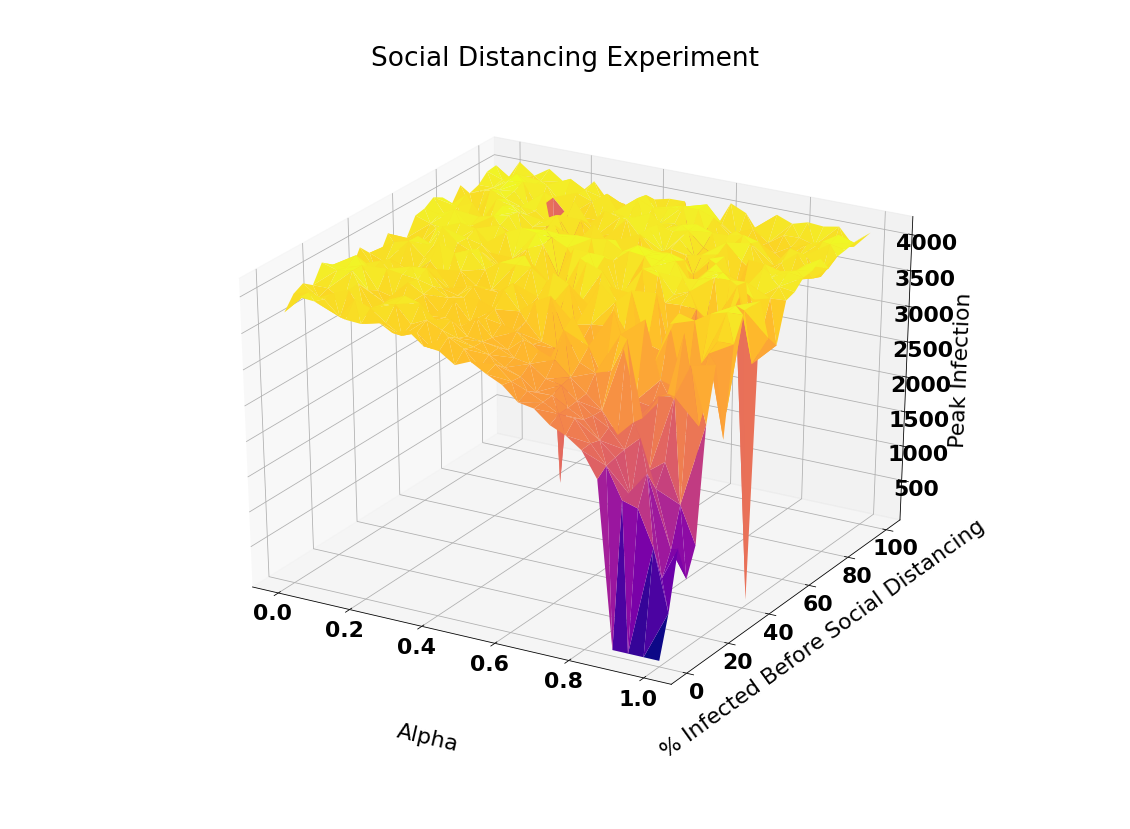

In [143]:
alphas_x, percents_y, peaks_z = readGeneratedData('data/sayermaxinfection.txt')
plotSocialExperiment(alphas_x, percents_y, peaks_z, "\nAlpha", "\n\n% Infected Before Social Distancing", "\n\nPeak Infection", "Social Distancing Experiment")

The cell below shows the same plot, just zoomed in on the lower 25% of the y axis. 

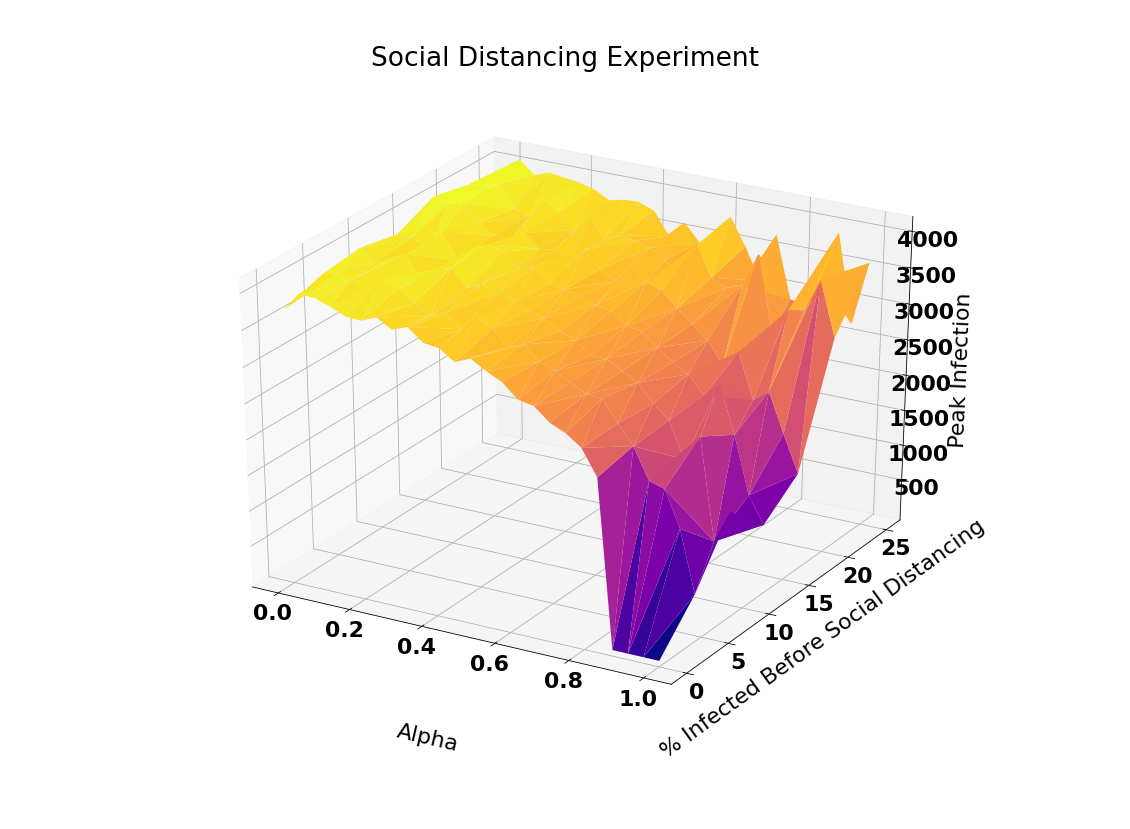

In [144]:
#Filter the points in order to "zoom in" on interesting sections of the plot
alphas_x_filtered = []
percents_y_filtered = []
peaks_z_filtered = []

for i in range(len(alphas_x)):
    if(percents_y[i] <= 25):
        alphas_x_filtered.append(alphas_x[i])
        percents_y_filtered.append(percents_y[i])
        peaks_z_filtered.append(peaks_z[i])

plotSocialExperiment(alphas_x_filtered, percents_y_filtered, peaks_z_filtered, "\nAlpha", "\n\n% Infected Before Social Distancing", "\n\nPeak Infection", "Social Distancing Experiment")

Now we wish to pull in data from the batch job so we can average it and get some smooth plots. The following cell should only need to be run once for each directory that contains data which needs averaging. 

In [67]:
#Reads all of the files in dirname and averages the third value on each line of each file
#Writes out to a file called filename with the averaged data
def averageDataDirectory(dirname, wildcard, filename):
    df = None
    flag = 0
    datacols = ['data']
    #Read all of the files in a directory and generate a new dataframe
    for filepath in glob.iglob(dirname + '/' + wildcard):

        df_temp = pd.read_csv(filepath, sep='\s+', header=None, names=['alpha', 'percent', 'data'])

        if df is None:
            df = df_temp
            flag += 1
        else:
            #Discard other columns than data
            df_temp = df_temp[['data']]

            #Rename column
            colname = 'data' + str(flag)

            #Concatenate with df
            df[colname] = df_temp['data']
            df[colname] = df[colname].astype(int)

            flag += 1
            datacols.append(colname)

    #Obtain a column that is the average of the others
    df['average'] = df[datacols].mean(axis=1)

    #Drop the other data columns 
    df.drop(datacols, axis=1, inplace=True)

    df.to_csv(filename, sep=' ', header=False, index=False)

In [68]:
dirname_base = 'data/generated/'
filename = 'averaged.txt'
wildcard = '*rep*.txt'
dirnames = ['maxinfected', 'maxasymptomatic', 'maxsymptomatic', 'maxsevere']

for dirname in dirnames:
    averageDataDirectory(dirname_base + dirname, wildcard, dirname_base + dirname + '/' + filename)

Now that the data has been averaged, we can generate plots from the data. The cells below will complete this function.

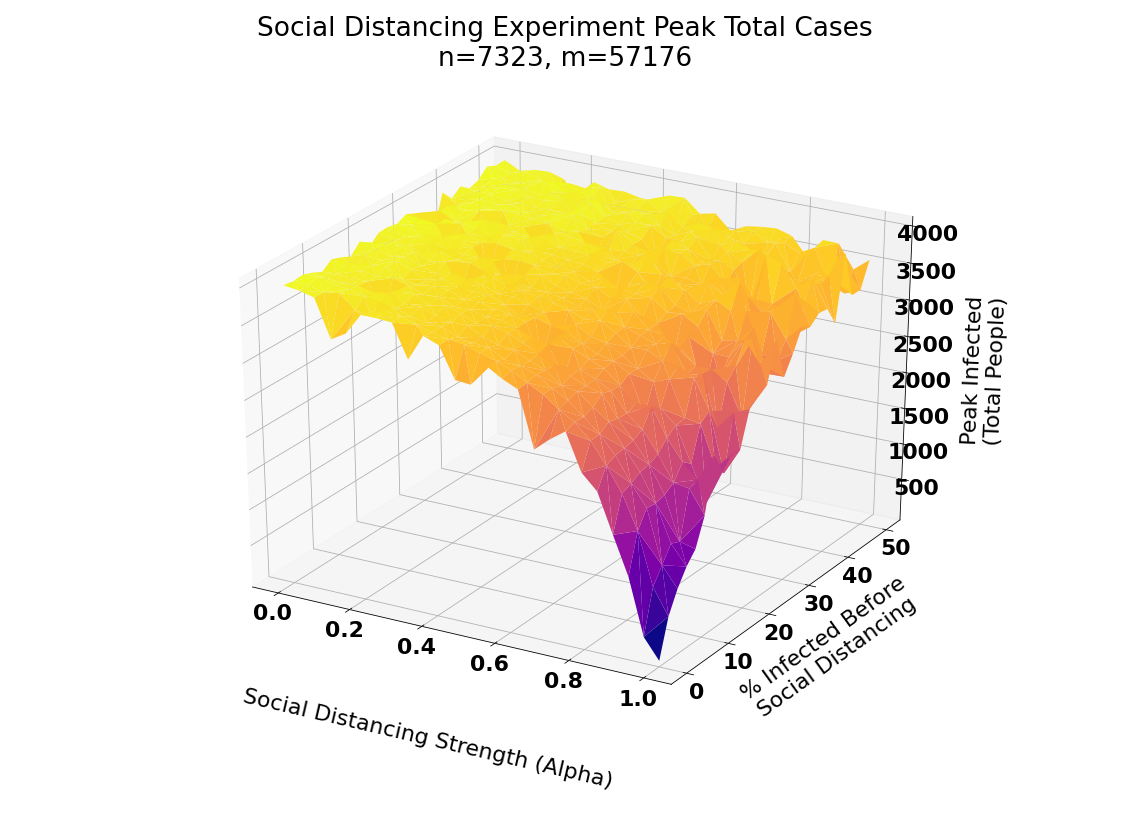

In [107]:
alphas_x, percents_y, peaks_z = readGeneratedData('data/generated/maxinfected/averaged.txt')
plotSocialExperiment(alphas_x, percents_y, peaks_z, "\nSocial Distancing Strength (Alpha)", "\n\n\n% Infected Before\nSocial Distancing", "\n\n\n\nPeak Infected\n(Total People)", "Social Distancing Experiment Peak Total Cases\nn=7323, m=57176")

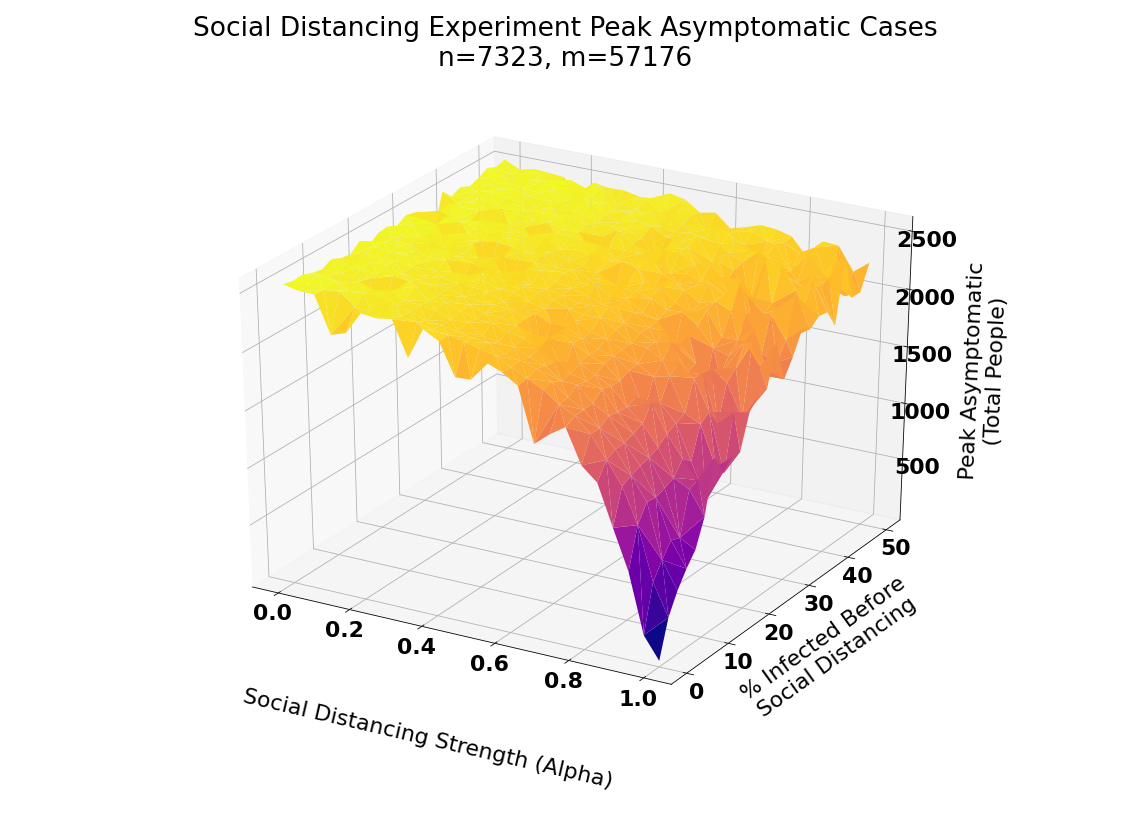

In [108]:
alphas_x, percents_y, peaks_z = readGeneratedData('data/generated/maxasymptomatic/averaged.txt')
plotSocialExperiment(alphas_x, percents_y, peaks_z, "\nSocial Distancing Strength (Alpha)", "\n\n\n% Infected Before\nSocial Distancing", "\n\n\n\nPeak Asymptomatic\n(Total People)", "Social Distancing Experiment Peak Asymptomatic Cases\nn=7323, m=57176")

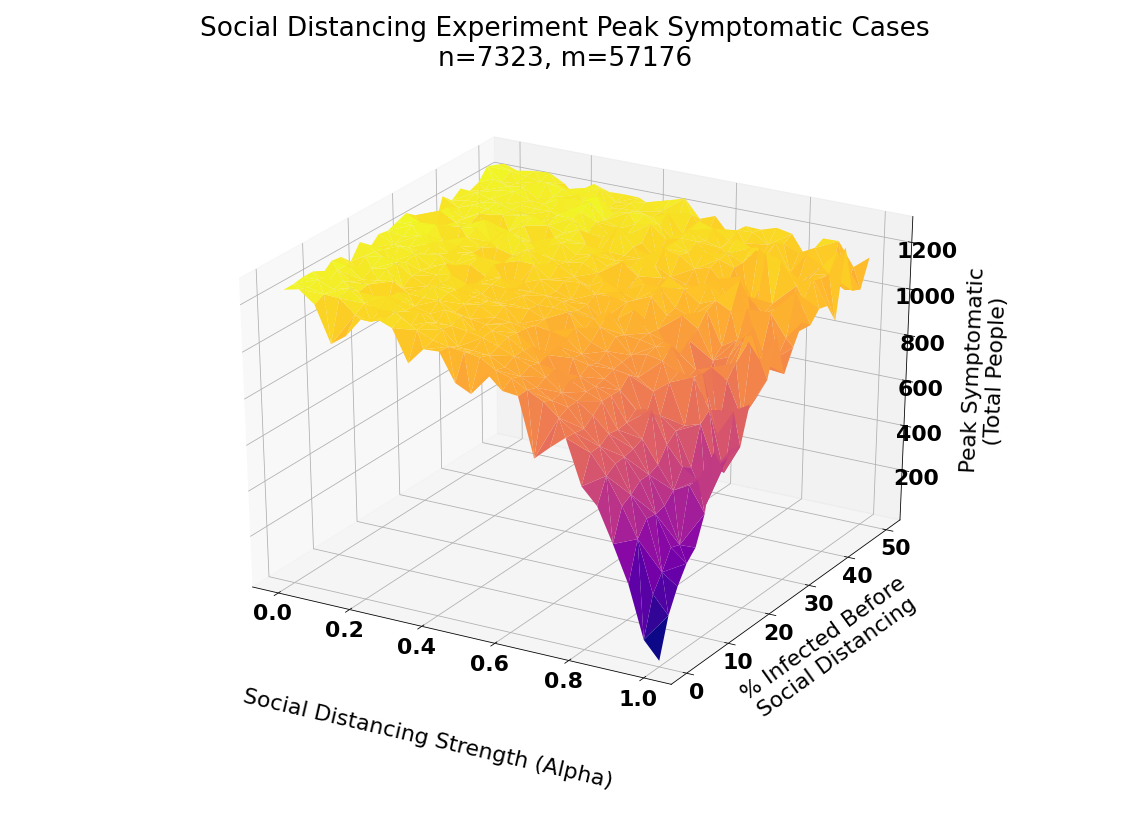

In [109]:
alphas_x, percents_y, peaks_z = readGeneratedData('data/generated/maxsymptomatic/averaged.txt')
plotSocialExperiment(alphas_x, percents_y, peaks_z, "\nSocial Distancing Strength (Alpha)", "\n\n\n% Infected Before\nSocial Distancing", "\n\n\n\nPeak Symptomatic\n(Total People)", "Social Distancing Experiment Peak Symptomatic Cases\nn=7323, m=57176")

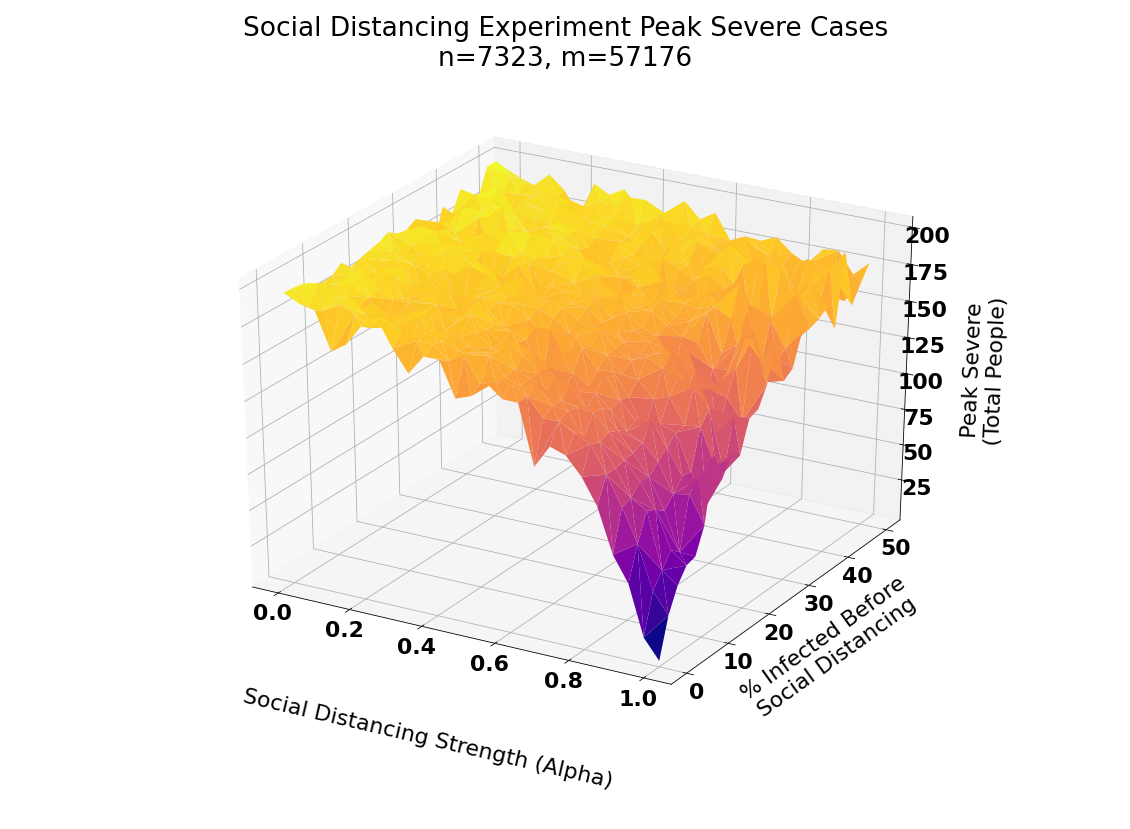

In [110]:
alphas_x, percents_y, peaks_z = readGeneratedData('data/generated/maxsevere/averaged.txt')
plotSocialExperiment(alphas_x, percents_y, peaks_z, "\nSocial Distancing Strength (Alpha)", "\n\n\n% Infected Before\nSocial Distancing", "\n\n\n\nPeak Severe\n(Total People)", "Social Distancing Experiment Peak Severe Cases\nn=7323, m=57176")